 use neural network to predict the change in the ecmwf-eps from the previous cycle run 12 hours ago for days 9-14
 ### current model features
- the difference between the new ecmwf forecast for day 9 and the previous emcwf-eps forecast for day 9[x]
- the difference between the new emcwf-eps forecast for day 8 and the previous emcwf-eps forecast for day 8[x]
- the difference between the new gfs-ens-bc forecast for days 9-14 and the previous emcwf-eps forecast for days 9-14[x]
- the difference between the new cmc-ens forecast for days 9-14 and the new gfs-ens-bc  forecast for days 9-14[x]

### new feature ideas
- rain data
- wind data
- past errors
- ???

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from datetime import datetime, time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
import torch
import torch.nn as nn

In [3]:
path = "RawData"

In [4]:
def extract_date_time(filename):
    """
    extract the date and time from the filename
    :param filename:
    :return:
    """
    parts = filename.split('.')
    date = parts[1]
    time = parts[2]
    return date, time

In [5]:
def get_date(df, file):
    """get the date from the dataframe and the time from the filename and combine them into a datetime object
    :param df: dataframe containing the date
    :param file: filename containing the time
    :return: datetime object
    """
    #date_str = df[df.iloc[:, 2] == 1].iloc[0]['Date']
    date_str = str(file.split('.')[1])
    time_str = str(file.split('.')[2])
    #date = datetime.strptime(date_str, '%Y-%m-%d')
    date = datetime.strptime(date_str, '%Y%m%d')
    time_value = time(int(time_str), 0)
    combined_datetime = datetime.combine(date.date(), time_value)
    return combined_datetime

In [6]:
ecmwf_files = glob.glob(path + '/ecmwf.*.[01][02].gw_hdd.csv')
ecmwf_sorted_files = sorted(ecmwf_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[3:]

ecmwf_eps_files = glob.glob(path + '/ecmwf-eps.*.[01][02].gw_hdd.csv')
ecmwf_eps_sorted_files = sorted(ecmwf_eps_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

gfs_ens_bc_files = glob.glob(path + '/gfs-ens-bc.*.[01][02].gw_hdd.csv')
gfs_ens_bc_sorted_files = sorted(gfs_ens_bc_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

cmc_ens_files = glob.glob(path + '/cmc-ens.*.[01][02].gw_hdd.csv')
cmc_ens_sorted_files = sorted(cmc_ens_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

In [7]:
for _ in range(2):
    set1 = set((extract_date_time(filename) for filename in ecmwf_sorted_files))
    set2 = set((extract_date_time(filename) for filename in ecmwf_eps_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in set2]
    ecmwf_eps_sorted_files = [filename for filename in ecmwf_eps_sorted_files if extract_date_time(filename) in set1]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in set1]

    master_set = set((extract_date_time(filename) for filename in cmc_ens_sorted_files))
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if extract_date_time(filename) in master_set]

    master_set = set((extract_date_time(filename) for filename in gfs_ens_bc_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in master_set]
    ecmwf_eps_sorted_files = [filename for filename in ecmwf_eps_sorted_files if extract_date_time(filename) in master_set]
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if extract_date_time(filename) in master_set]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in master_set]

In [8]:
print(len(ecmwf_sorted_files))
print(len(ecmwf_eps_sorted_files))
print(len(gfs_ens_bc_sorted_files))
print(len(cmc_ens_sorted_files))

3484
3484
3484
3484


### step 1 get changes in ecmwf-eps compared to 12 hours ago for days 9-14

In [9]:
ecmwf_eps_change_df = pd.DataFrame(columns=['ecmwf-eps_9', 'ecmwf-eps_10', 'ecmwf-eps_11', 'ecmwf-eps_12',
                                  'ecmwf-eps_13', 'ecmwf-eps_14'])

for i in range(1, len(ecmwf_eps_sorted_files)):
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i])
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 != d1:
        offset = 1
    else:
        offset = 0

    changes = []
    for day in range(8, 14):
        changes.append(ecmwf_eps_df.iloc[day - offset]['Value'] - prev_ecmwf_eps_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=ecmwf_eps_change_df.columns, index=[date])
    ecmwf_eps_change_df = pd.concat([ecmwf_eps_change_df, new_row])


## step 2 recreate model

### step 2.1 get difference between the new ecmwf forecast for day 9 and the previous ecmwf-eps forecast for day 9

### problems:
- not all dates are in both sets of data

In [10]:
ecmwf_change_df = pd.DataFrame(columns=['ecmwf_diff_8', 'ecmwf_diff_9',])
for i in range(1, len(ecmwf_sorted_files)):
    ecmwf_df = pd.read_csv(ecmwf_sorted_files[i])
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1]) #one day behind

    ecmwf = ecmwf_df.iloc[8]
    ecmwf_eps = ecmwf_eps_df.iloc[9]

    date =get_date(ecmwf_df, ecmwf_sorted_files[i])
    changes = []
    for day in range(8,10):
        changes.append(ecmwf_df.iloc[day]['Value'] - ecmwf_eps_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=ecmwf_change_df.columns, index=[date])
    ecmwf_change_df = pd.concat([ecmwf_change_df, new_row])

In [11]:
ecmwf_change_df

,ecmwf_diff_8,ecmwf_diff_9
2018-07-11 00:00:00,-0.002,0.005
2018-07-11 12:00:00,0.002,0.000
2018-07-12 00:00:00,0.003,0.002
2018-07-12 12:00:00,0.000,0.002
2018-07-13 00:00:00,0.000,0.000
...,...,...
2023-05-15 00:00:00,-1.429,3.291
2023-05-15 12:00:00,-0.251,-0.294
2023-05-16 00:00:00,3.552,-0.150
2023-05-16 12:00:00,-0.022,0.218


### step 2.2 the difference between the new emcwf-eps forecast for day 8 and the previous emcwf-eps forecast for day 8 (not possible as the new ecmwf-eps forecast is not available because it will not be released yet???)

### step 2.3 the difference between the new gfs-ens-bc forecast for days 9-14 and the previous emcwf-eps forecast for days 9-14

In [12]:
gfs_ens_bc_change_df = pd.DataFrame(columns=['gfs-ens-bc_9', 'gfs-ens-bc_10', 'gfs-ens-bc_11', 'gfs-ens-bc_12',
                                  'gfs-ens-bc_13', 'gfs-ens-bc_14'])

for i in range(1, len(gfs_ens_bc_sorted_files)):
    gfs_ens_bc_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    date = get_date(gfs_ens_bc_df, gfs_ens_bc_sorted_files[i])

    changes = []
    for day in range(8, 14):
        changes.append(gfs_ens_bc_df.iloc[day]['Value'] - prev_ecmwf_eps_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=gfs_ens_bc_change_df.columns, index=[date])
    gfs_ens_bc_change_df = pd.concat([gfs_ens_bc_change_df, new_row])

In [13]:
gfs_ens_bc_change_df

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14
2018-07-11 00:00:00,0.003,0.004,0.000,0.011,0.015,0.014
2018-07-11 12:00:00,0.004,0.001,0.000,0.005,0.008,0.018
2018-07-12 00:00:00,0.004,0.000,0.004,0.011,0.018,0.024
2018-07-12 12:00:00,0.001,0.002,0.004,0.009,0.021,0.015
2018-07-13 00:00:00,0.000,0.002,0.008,0.024,0.020,0.009
...,...,...,...,...,...,...
2023-05-15 00:00:00,-0.899,3.317,-0.923,-1.853,0.098,-0.197
2023-05-15 12:00:00,0.403,-0.348,-0.853,0.580,1.175,0.265
2023-05-16 00:00:00,3.752,-0.431,-1.366,0.107,-0.920,0.500
2023-05-16 12:00:00,0.203,0.060,1.151,0.556,0.098,-0.652


### step 2.4 the difference between the new cmc-ens forecast for days 9-14 and the new gfs-ens-bc  forecast for days 9-14

In [14]:
cmc_ens_change_df = pd.DataFrame(columns=['cmc-ens_9', 'cmc-ens_10', 'cmc-ens_11', 'cmc-ens_12',
                                  'cmc-ens_13', 'cmc-ens_14'])

for i in range(1, len(cmc_ens_sorted_files)):
    cmc_ens_df = pd.read_csv(cmc_ens_sorted_files[i])
    gfs_ens_bc_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    date = get_date(cmc_ens_df, cmc_ens_sorted_files[i])

    changes = []
    for day in range(8, 14):
        changes.append(cmc_ens_df.iloc[day]['Value'] - gfs_ens_bc_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=cmc_ens_change_df.columns, index=[date])
    cmc_ens_change_df = pd.concat([cmc_ens_change_df, new_row])

In [15]:
cmc_ens_change_df

,cmc-ens_9,cmc-ens_10,cmc-ens_11,cmc-ens_12,cmc-ens_13,cmc-ens_14
2018-07-11 00:00:00,-0.006,-0.003,-0.001,-0.013,-0.014,-0.012
2018-07-11 12:00:00,-0.003,-0.002,-0.001,-0.005,-0.008,-0.016
2018-07-12 00:00:00,-0.004,-0.002,-0.006,-0.009,-0.017,-0.019
2018-07-12 12:00:00,-0.002,-0.002,-0.004,-0.008,-0.013,-0.007
2018-07-13 00:00:00,-0.001,-0.003,-0.008,-0.022,-0.021,-0.013
...,...,...,...,...,...,...
2023-05-15 00:00:00,-0.631,0.232,0.894,-0.599,-1.595,-0.775
2023-05-15 12:00:00,-0.591,-0.005,0.499,-1.314,-2.503,-0.942
2023-05-16 00:00:00,-0.279,0.012,-1.454,-1.532,-0.951,0.255
2023-05-16 12:00:00,-0.481,-0.476,-1.847,-1.399,-0.814,0.066


In [16]:
master_df = pd.concat([gfs_ens_bc_change_df, cmc_ens_change_df, ecmwf_change_df, ecmwf_eps_change_df], axis=1)

In [17]:
master_df

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,cmc-ens_9,cmc-ens_10,cmc-ens_11,cmc-ens_12,cmc-ens_13,cmc-ens_14,ecmwf_diff_8,ecmwf_diff_9,ecmwf-eps_9,ecmwf-eps_10,ecmwf-eps_11,ecmwf-eps_12,ecmwf-eps_13,ecmwf-eps_14
2018-07-11 00:00:00,0.003,0.004,0.000,0.011,0.015,0.014,-0.006,-0.003,-0.001,-0.013,-0.014,-0.012,-0.002,0.005,0.001,-0.001,0.000,0.000,0.000,0.000
2018-07-11 12:00:00,0.004,0.001,0.000,0.005,0.008,0.018,-0.003,-0.002,-0.001,-0.005,-0.008,-0.016,0.002,0.000,0.001,0.000,-0.001,-0.001,-0.001,-0.001
2018-07-12 00:00:00,0.004,0.000,0.004,0.011,0.018,0.024,-0.004,-0.002,-0.006,-0.009,-0.017,-0.019,0.003,0.002,-0.001,-0.001,0.000,0.000,-0.001,0.001
2018-07-12 12:00:00,0.001,0.002,0.004,0.009,0.021,0.015,-0.002,-0.002,-0.004,-0.008,-0.013,-0.007,0.000,0.002,0.000,-0.001,0.001,0.001,0.006,0.003
2018-07-13 00:00:00,0.000,0.002,0.008,0.024,0.020,0.009,-0.001,-0.003,-0.008,-0.022,-0.021,-0.013,0.000,0.000,0.000,-0.001,-0.001,-0.002,0.000,-0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15 00:00:00,-0.899,3.317,-0.923,-1.853,0.098,-0.197,-0.631,0.232,0.894,-0.599,-1.595,-0.775,-1.429,3.291,0.141,0.055,-0.230,-0.270,-0.257,0.014
2023-05-15 12:00:00,0.403,-0.348,-0.853,0.580,1.175,0.265,-0.591,-0.005,0.499,-1.314,-2.503,-0.942,-0.251,-0.294,-0.195,-0.020,-0.281,-0.132,0.050,-0.327
2023-05-16 00:00:00,3.752,-0.431,-1.366,0.107,-0.920,0.500,-0.279,0.012,-1.454,-1.532,-0.951,0.255,3.552,-0.150,-0.035,-0.254,-0.293,-0.192,-0.102,-0.086
2023-05-16 12:00:00,0.203,0.060,1.151,0.556,0.098,-0.652,-0.481,-0.476,-1.847,-1.399,-0.814,0.066,-0.022,0.218,0.261,0.335,0.252,0.221,0.176,0.538


In [18]:
master_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gfs-ens-bc_9,3483.0,0.005592,1.608737,-9.259,-0.4110,0.005,0.3285,8.861
gfs-ens-bc_10,3483.0,-0.006345,1.645453,-9.384,-0.4650,0.007,0.3485,8.933
gfs-ens-bc_11,3483.0,0.013102,1.696030,-9.541,-0.5275,0.010,0.4385,9.373
gfs-ens-bc_12,3483.0,0.032291,1.761546,-10.504,-0.5910,0.014,0.5090,9.050
gfs-ens-bc_13,3483.0,0.044297,1.815628,-11.370,-0.6115,0.022,0.6430,9.668
gfs-ens-bc_14,3483.0,0.045904,1.853364,-8.661,-0.6350,0.026,0.7030,9.547
cmc-ens_9,3483.0,0.018010,0.736541,-3.877,-0.3375,-0.006,0.2985,3.211
cmc-ens_10,3483.0,0.091886,0.830035,-4.180,-0.2780,-0.005,0.4270,3.944
cmc-ens_11,3483.0,0.135222,0.945818,-3.731,-0.2740,-0.002,0.5465,4.920
cmc-ens_12,3483.0,0.154785,1.084122,-6.200,-0.3160,-0.004,0.6265,5.869


### random forest - mse=0.65

In [19]:
X = master_df.iloc[:, :14]

In [20]:
y = master_df.iloc[:, 14:]

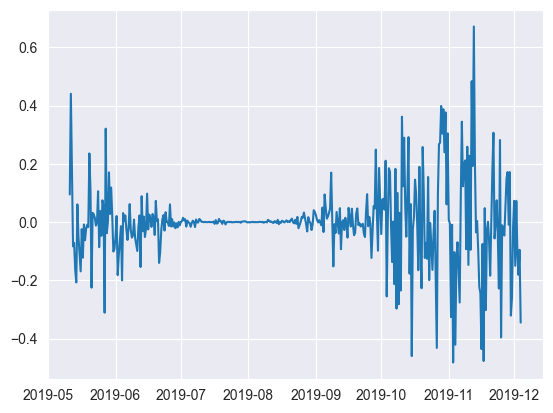

In [21]:
plt.plot(y['ecmwf-eps_9'][600:1000])

In [22]:
X

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,cmc-ens_9,cmc-ens_10,cmc-ens_11,cmc-ens_12,cmc-ens_13,cmc-ens_14,ecmwf_diff_8,ecmwf_diff_9
2018-07-11 00:00:00,0.003,0.004,0.000,0.011,0.015,0.014,-0.006,-0.003,-0.001,-0.013,-0.014,-0.012,-0.002,0.005
2018-07-11 12:00:00,0.004,0.001,0.000,0.005,0.008,0.018,-0.003,-0.002,-0.001,-0.005,-0.008,-0.016,0.002,0.000
2018-07-12 00:00:00,0.004,0.000,0.004,0.011,0.018,0.024,-0.004,-0.002,-0.006,-0.009,-0.017,-0.019,0.003,0.002
2018-07-12 12:00:00,0.001,0.002,0.004,0.009,0.021,0.015,-0.002,-0.002,-0.004,-0.008,-0.013,-0.007,0.000,0.002
2018-07-13 00:00:00,0.000,0.002,0.008,0.024,0.020,0.009,-0.001,-0.003,-0.008,-0.022,-0.021,-0.013,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15 00:00:00,-0.899,3.317,-0.923,-1.853,0.098,-0.197,-0.631,0.232,0.894,-0.599,-1.595,-0.775,-1.429,3.291
2023-05-15 12:00:00,0.403,-0.348,-0.853,0.580,1.175,0.265,-0.591,-0.005,0.499,-1.314,-2.503,-0.942,-0.251,-0.294
2023-05-16 00:00:00,3.752,-0.431,-1.366,0.107,-0.920,0.500,-0.279,0.012,-1.454,-1.532,-0.951,0.255,3.552,-0.150
2023-05-16 12:00:00,0.203,0.060,1.151,0.556,0.098,-0.652,-0.481,-0.476,-1.847,-1.399,-0.814,0.066,-0.022,0.218


In [23]:
y

,ecmwf-eps_9,ecmwf-eps_10,ecmwf-eps_11,ecmwf-eps_12,ecmwf-eps_13,ecmwf-eps_14
2018-07-11 00:00:00,0.001,-0.001,0.000,0.000,0.000,0.000
2018-07-11 12:00:00,0.001,0.000,-0.001,-0.001,-0.001,-0.001
2018-07-12 00:00:00,-0.001,-0.001,0.000,0.000,-0.001,0.001
2018-07-12 12:00:00,0.000,-0.001,0.001,0.001,0.006,0.003
2018-07-13 00:00:00,0.000,-0.001,-0.001,-0.002,0.000,-0.001
...,...,...,...,...,...,...
2023-05-15 00:00:00,0.141,0.055,-0.230,-0.270,-0.257,0.014
2023-05-15 12:00:00,-0.195,-0.020,-0.281,-0.132,0.050,-0.327
2023-05-16 00:00:00,-0.035,-0.254,-0.293,-0.192,-0.102,-0.086
2023-05-16 12:00:00,0.261,0.335,0.252,0.221,0.176,0.538


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=100, random_state=42)

In [26]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, n_estimators=1000, random_state=42)

In [27]:
y_pred = rf_model.predict(X_test)

In [28]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.2014817557442873


### RNN

In [29]:
master_df

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,cmc-ens_9,cmc-ens_10,cmc-ens_11,cmc-ens_12,cmc-ens_13,cmc-ens_14,ecmwf_diff_8,ecmwf_diff_9,ecmwf-eps_9,ecmwf-eps_10,ecmwf-eps_11,ecmwf-eps_12,ecmwf-eps_13,ecmwf-eps_14
2018-07-11 00:00:00,0.003,0.004,0.000,0.011,0.015,0.014,-0.006,-0.003,-0.001,-0.013,-0.014,-0.012,-0.002,0.005,0.001,-0.001,0.000,0.000,0.000,0.000
2018-07-11 12:00:00,0.004,0.001,0.000,0.005,0.008,0.018,-0.003,-0.002,-0.001,-0.005,-0.008,-0.016,0.002,0.000,0.001,0.000,-0.001,-0.001,-0.001,-0.001
2018-07-12 00:00:00,0.004,0.000,0.004,0.011,0.018,0.024,-0.004,-0.002,-0.006,-0.009,-0.017,-0.019,0.003,0.002,-0.001,-0.001,0.000,0.000,-0.001,0.001
2018-07-12 12:00:00,0.001,0.002,0.004,0.009,0.021,0.015,-0.002,-0.002,-0.004,-0.008,-0.013,-0.007,0.000,0.002,0.000,-0.001,0.001,0.001,0.006,0.003
2018-07-13 00:00:00,0.000,0.002,0.008,0.024,0.020,0.009,-0.001,-0.003,-0.008,-0.022,-0.021,-0.013,0.000,0.000,0.000,-0.001,-0.001,-0.002,0.000,-0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15 00:00:00,-0.899,3.317,-0.923,-1.853,0.098,-0.197,-0.631,0.232,0.894,-0.599,-1.595,-0.775,-1.429,3.291,0.141,0.055,-0.230,-0.270,-0.257,0.014
2023-05-15 12:00:00,0.403,-0.348,-0.853,0.580,1.175,0.265,-0.591,-0.005,0.499,-1.314,-2.503,-0.942,-0.251,-0.294,-0.195,-0.020,-0.281,-0.132,0.050,-0.327
2023-05-16 00:00:00,3.752,-0.431,-1.366,0.107,-0.920,0.500,-0.279,0.012,-1.454,-1.532,-0.951,0.255,3.552,-0.150,-0.035,-0.254,-0.293,-0.192,-0.102,-0.086
2023-05-16 12:00:00,0.203,0.060,1.151,0.556,0.098,-0.652,-0.481,-0.476,-1.847,-1.399,-0.814,0.066,-0.022,0.218,0.261,0.335,0.252,0.221,0.176,0.538


In [30]:
input_data = master_df.iloc[:, :-6].values
target_data = master_df.iloc[:, -6:].values

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [77]:
#split data into train, val, test
#train = 70%, val = 20%, test = 10%

train_df = master_df[:int(len(master_df)*0.7)]
val_df = master_df[int(len(master_df)*0.7):int(len(master_df)*0.9)]
test_df = master_df[int(len(master_df)*0.9):]


In [ ]:
#normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
df_std = (master_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(master_df.keys(), rotation=90)